<a href="https://colab.research.google.com/github/RitaRez/POC/blob/main/bm25_and_pl2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalações

Para indexação e ranqueamento utilizaremos a mesma biblioteca utilizada em ... ```pyTerrier```

In [1]:
!pip install python-terrier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.5/311.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.2/287.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━

# Bibliotecas e Dados utilizados

```pandas``` para manipular DataFrames, ```pyterrier``` para indexação e retrieval, ```json``` e ```re``` para manipular queries e documents.

In [5]:
import json, re

import pyterrier as pt
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from google.colab import drive

Vamos realizar o mount para acessar os dados do Drive

In [3]:
drive.mount('/content/drive')

if not pt.started():
  pt.init()

Mounted at /content/drive
terrier-assemblies 5.7 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.7 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7



In [4]:
path = "/content/drive/My Drive/ToT/"
!ls "/content/drive/My Drive/ToT"

Index  Movies


# Indexação

O corpus presente em documents.json e negative_documents.json é indexado e armazenado no Drive em ```/ToT/Index/```

In [ ]:
def parse_documents(documents_file):

  documents = []
  with open(documents_file, 'rt') as file:
    for l in file:
      new_doc = json.loads(l)

      new_doc['docno'] = new_doc['id']
      del new_doc['id']

      documents.append(new_doc)
  
  return documents

def index_corpus(documents_file, negative_documents_file, index_path):
  """
  Indexes the corpus
  """
  
  documents = parse_documents(documents_file) + parse_documents(negative_documents_file)
  
  # build the index
  indexer = pt.IterDictIndexer(index_path, verbose=True, meta={'docno': 20, 'text': 4096, 'title': 4096}, meta_reverse = ["docno"])
  return indexer.index(documents, meta=["docno"])


indexref = index_corpus(path + 'Movies/documents.json', path + 'Movies/negative_documents.json', path + 'Index/index')

# load the index, print the statistics
index = pt.IndexFactory.of(indexref)
print(index.getCollectionStatistics().toString())

<ipython-input-9-955902a80faf>:24: DeprecationWarning: specifying meta and meta_lengths in IterDictIndexer.index() is deprecated, use constructor instead
  return indexer.index(documents, meta=["docno"])


00:56:29.098 [ForkJoinPool-3-worker-3] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (tt0490879) - further warnings are suppressed
00:56:34.270 [ForkJoinPool-3-worker-3] WARN org.terrier.structures.indexing.Indexer - Indexed 29 empty documents
Number of documents: 13642
Number of terms: 57368
Number of postings: 1679218
Number of fields: 1
Number of tokens: 2609710
Field names: [text]
Positions:   false



# Leitura de Arquivos para Experimentos

### Leitura de consultas e preprocessamento

* Tiramos pontuação, *stopwords* e realizamos *stemming*.

In [6]:
topics_path = path + 'Movies/queries.json'

qids = []; queries = []
with open(topics_path, 'rt') as file:
  for l in file:
    new_doc = json.loads(l)
    title = re.sub(r'[^\w\s]', ' ', new_doc['title'])
    description = re.sub(r'[^\w\s]', ' ', new_doc['description'])

    qids.append(new_doc['id'])
    queries.append(title + " " + description)

topics = pd.DataFrame({"qid": qids, "query": queries})

topics.head(4)

,qid,query
0,cggmzb,TOMT ANIMATION Little girl turns out to be ...
1,9g2x0f,TOMT Movie Late 90s Kids messed up turned...
2,eitiw9,TOMT MOVIE 2000s Teens investigate remote ...
3,km8f9u,tomt movie 1990 s 2000 s witch movie mo...


### Leitura do arquivo *qrels* que mapeia consultas, documentos e se é relevante ou não.

In [7]:
qrels_path = path + 'Movies/qrels.txt'

qrels = pt.io.read_qrels(qrels_path)
qrels.head(4)

,qid,docno,label
0,5lj3jl,tt0478303,1
1,5lldhi,tt2618986,1
2,5lmsd4,tt0240772,1
3,5m467z,tt1133691,1


### Leitura do arquivo *qrels* negativo que mapeia consultas, documentos e se é relevante ou não.

Também retirado do reddit, no caso são comentários com respostas erradas.

In [8]:
hard_negatives = path + "Movies/sub_id_to_neg_doc_ids.json"

querie_ids = []; doc_ids = []; labels = []
with open(hard_negatives, 'r') as hard_negatives:
  negatives = json.load(hard_negatives)
  
  for querie_id, doc_id in negatives.items():
    for doc in doc_id:
      querie_ids.append(querie_id)
      doc_ids.append(doc)
      labels.append(0)

negatives_qrels = pd.DataFrame({"qid": querie_ids, "docno": doc_ids, "label": labels})
negatives_qrels.head()

,qid,docno,label
0,arngub,tt1038988,0
1,eg0ze2,tt0162661,0
2,e67k4z,tt0376541,0
3,87izqh,tt0161743,0
4,87izqh,tt0092117,0


Agora vamos dividir em conjuntos de treino e teste!

In [9]:
train_topics, test_topics = train_test_split(topics, test_size=0.2)

# Encontrando os melhores Hyper Parametros

### BM25

Testaremos diferentes valores para **c**, **k1** e **k3**.

In [23]:
index = pt.IndexFactory.of(path + 'Index/index')

BM25 = pt.BatchRetrieve(index, wmodel="BM25", properties={"termpipelines" : "Stopwords,PorterStemmer"}, controls={"bm25.b" : 0.75, "bm25.k_1": 0.75, "bm25.k_3": 0.75})
rtr = pt.GridSearch(
    BM25,
    { BM25: {
            "bm25.b": [0.3, 0.7, 1],
            "bm25.k_1": [1.4, 2],
            "bm25.k_3": [0.5, 4] 
             }
     },
    train_topics,
    qrels,
    "recip_rank"
)

Best recip_rank is 0.125433
Best setting is ['BR(BM25) bm25.b=1', 'BR(BM25) bm25.k_1=1.4', 'BR(BM25) bm25.k_3=0.5']


Abaixo podemos ver os resultsdos:

### PL2

Testaremos diferentes valores para **c**.

In [25]:
pl2 = pt.BatchRetrieve(index, wmodel="PL2", properties={"termpipelines" : "Stopwords,PorterStemmer"}, controls={'c' : 1})
rtr = pt.GridScan(
    pl2,
    {pl2 : {'c' : [0.1, 1, 5, 10, 20, 100]}},
    train_topics,
    qrels,
    "recip_rank"
)

Abaixo podemos ver os resultados:

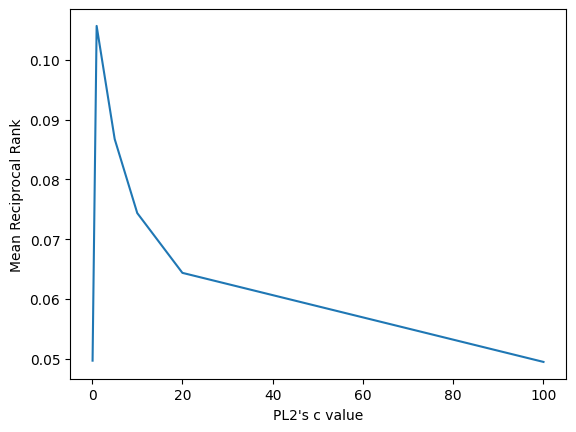

In [26]:
plt.plot(rtr["tran_0_c"], rtr["recip_rank"])
plt.xlabel("PL2's c value")
plt.ylabel("Mean Reciprocal Rank")
plt.show()

# Criação de Modelos para Retrieval

Vamos testar os modelos bm25, pls, tf_idf.

In [27]:
index = pt.IndexFactory.of(path + 'Index/index')
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF", properties={"termpipelines" : "Stopwords,PorterStemmer"})
bm25 = pt.BatchRetrieve(index, wmodel="BM25", properties={"termpipelines" : "Stopwords,PorterStemmer"}, controls={"bm25.b": 1, "bm25.k_1": 1.4, "bm25.k_3": 0.5})
pl2 = pt.BatchRetrieve(index, wmodel="PL2", properties={"termpipelines" : "Stopwords,PorterStemmer"}, controls={'c' : 1})

In [28]:
pt.Experiment(
    [tf_idf, bm25, pl2],
    test_topics,
    qrels,
    eval_metrics=["recall_1", "recall_10", "recip_rank"]
)

,name,recall_1,recall_10,recip_rank
0,BR(TF_IDF),0.103089,0.230116,0.145914
1,BR(BM25),0.115444,0.266795,0.169706
2,BR(PL2),0.100000,0.228571,0.143331
